In [6]:
%matplotlib inline
import os
import sys
import numpy as np

#uncomment if cloned from github!
sys.path.append("../")

from sapsan.lib.backends.fake import FakeBackend
from sapsan.lib.backends.mlflow import MLflowBackend
from sapsan.lib.data.flatten_dataset import FlattenDataset
from sapsan.lib.data import EquidistanceSampling
from sapsan.lib.estimator import KRR, KRRConfig
from sapsan.lib.experiments.evaluate_3d import Evaluate3d
from sapsan.lib.experiments.evaluate_flatten import EvaluateFlatten
from sapsan.lib.experiments.train import Train

In [7]:
#--- Experiment tracking backend ---
experiment_name = "CNN experiment"

#Fake (disable backend)
tracking_backend = FakeBackend(experiment_name)

#MLflow
#launch mlflow with: mlflow ui --port=9000
#uncomment tracking_backend to use mlflow

MLFLOW_HOST = "localhost"
MLFLOW_PORT = 9000

#tracking_backend = MLflowBackend(experiment_name, MLFLOW_HOST, MLFLOW_PORT)

In [8]:
#--- Data setup ---
#In the intereset of loading and training multiple timesteps
#one can specify which checkpoints to use and where
#they appear in the path via syntax: {checkpoint:format}
#
#Next, you need to specify which features to load; let's assume 
#        path = "{feature}.h5"
#
# 1) If in different files, then specify features directly;
#    The default HDF5 label will be the last label in the file
#    Ex: features = ['velocity', 'denisty', 'pressure']
# 2) If in the same, then duplicate the name in features
#    and specify which labels to pull
#    Ex: features = ["data", "data", "data"]
#        feature_labels = ['velocity', 'density', 'pressure']

path = 'data/t{checkpoint:1.0f}/{feature}_dim128_2d.h5'
features = ['u']
target = ['u']

#dimensionality of the data
AXIS = 2

#Dimensionality of your data per axis
CHECKPOINT_DATA_SIZE = 128

#Reduce dimensionality of each axis to
SAMPLE_TO = 64

#Dimensionality of each axis in a batch
GRID_SIZE = 8

#Sampler to use for reduction
sampler = EquidistanceSampling(CHECKPOINT_DATA_SIZE, SAMPLE_TO, AXIS)

In [9]:
#--- Train the model ---
#Machine Learning model to use

#Configuration of the model parameters:
#    alpha - rbf kernel hyperparameter
#    gamma - rbf kernel hyperparameter
estimator = KRR(
    config=KRRConfig(gamma=1.778, alpha=0.001)
)

#Load the data
x, y = FlattenDataset(path=path,
                   features=features,
                   target=target,
                   checkpoints=[0],
                   sampler=sampler,
                   axis = AXIS).load()
#Set the experiment
training_experiment = Train(name=experiment_name,
                             backend=tracking_backend,
                             model=estimator,
                             inputs=x, targets=np.array([y[0]]))
#Train the model
training_experiment.run()

Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'
Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'


/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:187: LinAlgWarning:

Ill-conditioned matrix (rcond=4.14222e-08): result may not be accurate.



{'runtime': 2.3697712421417236}

Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'
Loading 'u00010' from file 'data/t0/u_dim128_2d.h5'


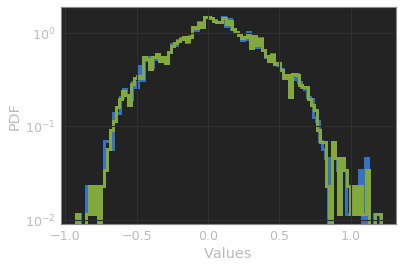

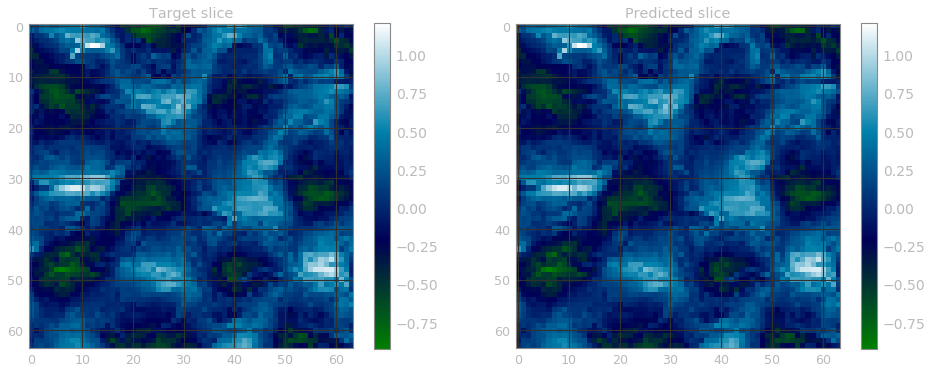

{'runtime': 2.3965015411376953}

In [10]:
#--- Test the model ---
#Load the test data
x, y = FlattenDataset(path=path,
                       features=features,
                       target=target,
                       checkpoints=[0],
                       sampler=sampler,
                       axis = AXIS).load()

#Set the test experiment
evaluation_experiment = EvaluateFlatten(name=experiment_name,
                                           backend=tracking_backend,
                                           model=training_experiment.model,
                                           inputs=x, targets=np.array([y[0]]),
                                           checkpoint_data_size=SAMPLE_TO,
                                           checkpoints=[0], axis = AXIS)

#Test the model
evaluation_experiment.run()